In [1]:
cd ../src

/home/sankha/Documents/programs/ML/densityNN/src


In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from lib.density.utils import divergences, OptimizeNormalKL
from scipy.stats import multivariate_normal, norm

# KL Divergence

Under certain circumstances, it is important to know how closely one probability density function (or, the probability mass function for the discrete case) matches another. The KL divergence measures how close one distribution $p(\theta)$ is with respect to another distribution $q(\theta)$. Note that the vectors over which the probability density(mass) functions are defined are the same for both the distributions.

For discrete distributions, the K-L divergence is defined by the following formula

\begin{align*}
\mathbb {KL}(p || q) = \sum_{x \in \chi} {P(\theta) \log {\frac {p(\theta)} {q(\theta)}}  }
\end{align*}

For continuous variables, this is represented by the integral. It is important to note that the KL divergence is not reciprocal, i.e. $\mathbb {KL}(p||q) \neq \mathbb {KL}(q||p)$.


## 1D distribution Example

In the following example, two Gaussian distributions are compared using the [KL Divergence](https://sankhamukherjee.github.io/densityNN/lib.density.utils.html#lib.density.utils.divergences.D_KL). These are:

$$p(\theta) = \mathcal N(2, 2)$$
$$q(\theta) = \mathcal N(\mu, 4), \mu \in [-2, 0, 2, 4]$$

We plot the values of $p(\theta)$, $q(\theta)$ and the expression for $p(\theta) \log \frac {p(\theta)} {q(\theta)}$. Note that as the two probabilities converge, the positive and negative parts of the expression of $p(\theta) \log \frac {p(\theta)} {q(\theta)}$ become equal to one another. This is also exemplified by the last figure in which the KL divergence is plotted over the range of the values calculated for $\mu$, wherein there appears to be a definite minima at which the KL divergence is the least, marked by the point wherein the PDF of the two distributions are most similar.


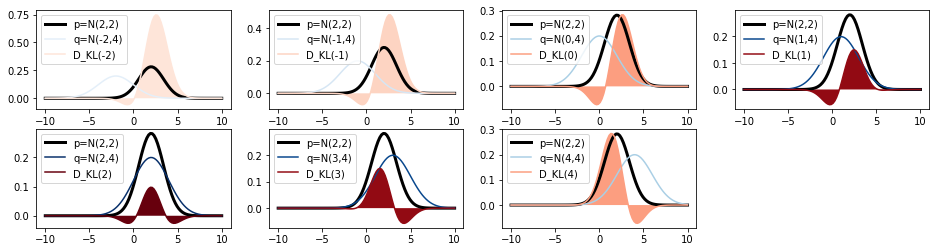

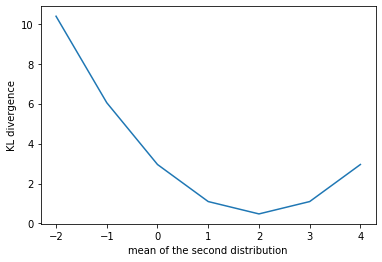

In [3]:
theta = np.linspace(-10, 10, 100).reshape((-1, 1))
mu_1  = np.array([2])
sigma_1 = np.array([2])
prob_1 = multivariate_normal.pdf(theta, mean=mu_1, cov=sigma_1)

divs = []
ms = np.array([-2, -1, 0, 1, 2, 3, 4])

nCols = 4
if len(ms) % nCols == 0:
    nRows = len(ms) // nCols
else:
    nRows = len(ms) // nCols + 1
    
plt.figure(figsize=(16, 4))
for i, m in enumerate(ms):
    
    plt.subplot( nRows, nCols, i+1)
    plt.plot(theta.flatten(), prob_1, label='p=N(2,2)', color='black', lw=3 )
    mu_2  = np.array([m])
    sigma_2 = np.array([4])
    prob_2 = multivariate_normal.pdf(theta, mean=mu_2, cov=sigma_2)

    div, div_all = divergences.D_KL(prob_1, prob_2, returnVals=True)
    divs.append( div )

    plt.plot(theta.flatten(), prob_2,  color= plt.cm.Blues( 1/div ) , label=f'q=N({m},4)' )
    plt.plot(theta.flatten(), div_all, color= plt.cm.Reds( 1/div ), label=f'D_KL({m})' )
    plt.fill_between(theta.flatten(), div_all, 0, fc =plt.cm.Reds( 1/div ))
    
    plt.legend()

plt.figure()
plt.plot(ms, divs)
plt.xlabel('mean of the second distribution')
plt.ylabel('KL divergence')

plt.show()
plt.close()

The last figure is significant. This suggests that one should be able to find an approximate distribution $q(\theta)$ that best approximates the provided probability distribution. In the following section, we shall explore this particular phenomenon. An [optimizer](https://sankhamukherjee.github.io/densityNN/lib.density.utils.html#lib.density.utils.OptimizeNormalKL.OptimizeNormalKL) will be used to find a $q = \mathcal N( \mu, \Sigma )$ that approximates any given probability distribution.

# Optimization

Given a normal distribution of $p = \mathcal N ( 2, 2 )$, we want to see whether we are able to find a Normal distribution that approximates this PDF. This is done in the following code:

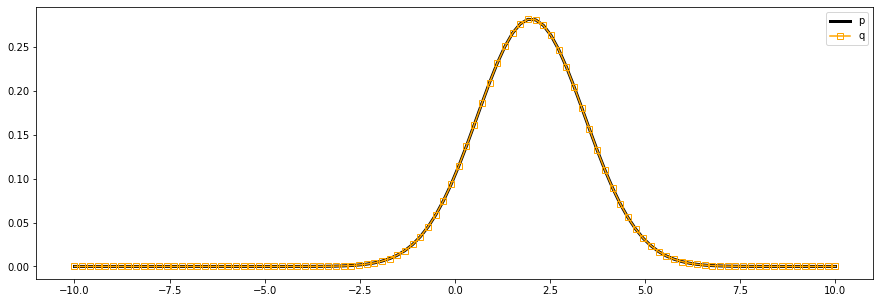

In [4]:
theta = np.linspace(-10, 10, 100).reshape((-1, 1))
mu_1  = np.array([2])
sigma_1 = np.array([2])
prob_1 = multivariate_normal.pdf(theta, mean=mu_1, cov=sigma_1)

mu0 = np.array([-1])
optKL = OptimizeNormalKL.OptimizeNormalKL(prob_1, theta)
q_optimized = optKL.optimize(mu0)


plt.figure(figsize=(15, 5))
plt.plot(theta.flatten(), prob_1, color='black', lw=3, label='p' )
plt.plot( theta.flatten(), q_optimized, 's-', color='orange', mfc='None', mec='orange',  label='q') 
plt.legend()
plt.show()
plt.close('all')

Similarly, this can be extended to *any* type of input distribution, as shown below

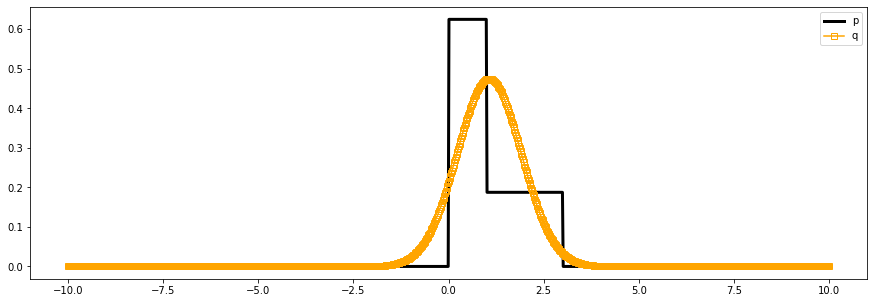

In [5]:
theta = np.linspace(-10, 10, 1000).reshape((-1, 1))

prob_1 = np.where( (theta>=0) & (theta<=1) , 1., 0).flatten()
prob_1 += (np.where( (theta>=1) & (theta<=3) , 1, 0).flatten())*0.3

total = prob_1.sum() * (20/1000)
prob_1 /= total

mu0 = np.array([-1])

optKL = OptimizeNormalKL.OptimizeNormalKL(prob_1, theta)
q_optimized = optKL.optimize(mu0)

plt.figure(figsize=(15, 5))
plt.plot(theta.flatten(), prob_1, color='black', lw=3, label='p' )
plt.plot( theta.flatten(), q_optimized, 's-', color='orange', mfc='None', mec='orange',  label='q') 
plt.legend()
plt.show()
plt.close('all')

## 2D Distribution Example

Now, we should be able to show the same thing for the N-dimensional case. Se shall attempt to learn an initial distribution:

\begin{align*}
p = \mathcal N \Big( \begin{bmatrix} 
    2 \\
    3
\end{bmatrix}, \begin{bmatrix} 
    3 & 0\\
    0 & 1 
\end{bmatrix} \Big)
\end{align*}

We would like to see whether we are able to find the multivariate distribution $q = \mathcal N(\mu, \Sigma)$ such that it approximates the above distribution

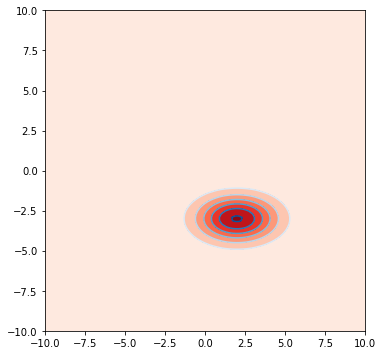

In [6]:
X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
theta = np.array(list(zip(X.flatten(), Y.flatten())))

mu    = np.array([2, -3])
sigma = np.array([
    [3, 0],
    [0, 1]
])

mu0  = np.array([0, 0])

prob = multivariate_normal.pdf( theta, mu, sigma )
optKL2D = OptimizeNormalKL.OptimizeNormalKL(prob, theta)
q_optimized = optKL2D.optimize(mu0)

probPlot = prob.reshape(100, 100)
q_optimizedPlot = q_optimized.reshape(100,100)

plt.figure(figsize=(5,5))
plt.axes([0.1, 0.1, 0.89, 0.89])
plt.contour(X, Y, probPlot, cmap=plt.cm.Blues)
plt.contourf(X, Y, q_optimizedPlot, cmap=plt.cm.Reds)
plt.show()
plt.close('all')

